<a href="https://colab.research.google.com/github/ShreyPandit/Volatility-Prediction-using-MAEC-Dataset/blob/main/Volatility_MAEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Earnings-Call-Dataset/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction.git

Cloning into 'MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction'...
remote: Enumerating objects: 4784, done.
remote: Counting objects: 100% (4784/4784), done.
remote: Compressing objects: 100% (2401/2401), done.
remote: Total 15104 (delta 22), reused 4756 (delta 6), pack-reused 10320
Receiving objects: 100% (15104/15104), 72.12 MiB | 25.58 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (9278/9278), done.


In [2]:
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

import pandas as pd

In [3]:
def gettxtfile(name):
  a = name.split('-')[0]
  company = a.split('_')[0]
  date = a.split('_')[1]
  base = '/content/MAEC-A-Multimodal-Aligned-Earnings-Conference-Call-Dataset-for-Financial-Risk-Prediction/MAEC_Dataset/'
  f = open(base+str(date) + str('_')+ str(company)+str('/')+'text.txt')
  a = f.read()
  return a

In [4]:
a = gettxtfile('A_20160817-00031.npy')

In [5]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

--2021-01-05 03:44:53--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   166MB/s    in 2.3s    

2021-01-05 03:44:55 (166 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [6]:
os.makedirs("model", exist_ok=True)
!mv uncased_L-12_H-768_A-12/ model
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

In [7]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

# Calculating the Average log volitility over 3 days

In [8]:
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import os
import numpy as np
from tqdm import tqdm
import math

In [9]:
def calcVol(stock,start):
  year = int(start[:4])
  month = int(start[4:6])
  day = int(start[6:])
  next_year = year
  next_month=month
  prev_month = month
  prev_year = year

  starting = datetime.datetime(year,month, day-1)

  if(month==12):
    next_month=1
    next_year = year+1
  else:
    next_month=month+1
  

  ending = datetime.datetime(next_year,next_month, day
                             )

  df= web.DataReader(stock,"yahoo",starting,ending)
  df = df.iloc[:3,:]
  return df


In [10]:
def calcVol2(stock,start):
  year = int(start[:4])
  month = int(start[4:6])
  day = int(start[6:])
  next_year = year
  next_month=month
  prev_month = month
  prev_year = year


  starting = datetime.datetime(year,month, day-1)

  if(month==12):
    next_month=1
    next_year = year+1
  else:
    next_month=month+1
  

  ending = datetime.datetime(next_year,next_month, day
                             )

  df= web.DataReader(stock,"yahoo",starting,ending)
  df = df.iloc[-4:,:]
  return df


In [11]:
def extract(name):
  stock_code = name.split('_')[0]
  date1 = name.split('_')[1]
  date = date1.split('-')[0]
  df1 = calcVol(stock_code,date)
  time = df1.index[-1]
  year_end = str(time.year)
  month_end = str(time.month)
  if (month_end == '01'):
    month_end  = '12'
    year_end = str((int(year_end)-1))
  else:
    month_end = str(int(month_end)-1)
  if (len(month_end)==1):
    month_end = str('0'+ month_end)
  date_end = str(time.day)
  if (len(date_end)==1):
    date_end = str('0'+ date_end)
   
  final_date = (str(year_end)+str(month_end)+str(date_end))
  df2 = calcVol2(stock_code,final_date)
  df2 = df2['Close'].values
  return df2

In [12]:
extract("A_20160817-00031.npy")

array([48.43999863, 48.27999878, 48.43000031, 46.72000122])

In [13]:
def calculatereturnprice(prev_day,curr_day):
  return (float(curr_day/prev_day)-1)

In [14]:
def calculateavlogvol(stock):
  df = extract(stock)
  rp1 = calculatereturnprice(df[0],df[1])
  rp2 = calculatereturnprice(df[1],df[2])
  rp3 = calculatereturnprice(df[2],df[3])
  #print(rp1,rp2,rp3)

  meanrp = float((rp1+rp2+rp3)/3)

  rp12 = np.square(float(rp1-meanrp))
  rp22 = np.square(float(rp2-meanrp))
  rp32 = np.square(float(rp3-meanrp))

  mean1 = float((rp12+rp22+rp32)/3)

  a = (math.sqrt(mean1))
  
  return np.log(a)

Creating CSV File

In [15]:
listofall = os.listdir('./drive/MyDrive/dataset/A')

In [19]:
dataset = pd.DataFrame(listofall)

In [21]:
textfile=[]
for a in listofall:
  b = gettxtfile(a)
  textfile.append(b)

In [22]:
dataset['Text'] = textfile

In [23]:
numpyfile = []
for a in listofall:
  b = np.load('./drive/MyDrive/dataset/A/'+str(a))
  numpyfile.append(b)

In [24]:
dataset['Numpy'] = numpyfile

In [25]:
dataset.columns

Index([0, 'Text', 'Numpy'], dtype='object')

In [ ]:
avvolitility = []
error = []
counter = []
count=0
for a in listofall:
  try:
    b = calculateavlogvol(a)
    avvolitility.append(b)
  except:
    print(a)
    error.append(a)
    counter.append(count)
  count+=1

In [27]:
dataset.set_index(0)

,Text,Numpy
0,,
ABC_20150723-00013.npy,Given that we're approaching the top of the ho...,"[[-0.59440446, -0.599903, -0.6007702, -0.60046..."
AAWW_20151105-00160.npy,"So, you know, we always do recurrent pilot tra...","[[-0.39618757, -0.39562544, -0.39341366, -0.39..."
ABT_20160420-00016.npy,"Yes, again I don't feel unreasonably constrain...","[[-0.46677017, -0.4666495, -0.46556017, -0.464..."
ABCB_20170421-00013.npy,"Thank you, <UNK> and good morning everyone and...","[[-0.55746734, -0.553412, -0.55489373, -0.5440..."
ABG_20180424-00172.npy,"Thanks, operator, and good morning, everyone.\...","[[-0.61008364, -0.61194575, -0.6090797, -0.609..."
...,...,...
AAON_20180227-00200.npy,"Good afternoon, ladies and gentlemen.\nWelcome...","[[-0.28450432, -0.28448093, -0.28348, -0.28156..."
AAWW_20151105-00188.npy,"So, you know, we always do recurrent pilot tra...","[[-0.48194563, -0.48171577, -0.4813952, -0.482..."
AAN_20170728-00131.npy,"Thank you, and good morning, everyone.\nWelcom...","[[-0.39801496, -0.3975194, -0.38705134, -0.373..."


In [41]:
for a in counter:
  dataset.drop(a,inplace=True)

In [44]:
dataset['Target'] = avvolitility
dataset

,0,Text,Numpy,Target
0,ABC_20150723-00013.npy,Given that we're approaching the top of the ho...,"[[-0.59440446, -0.599903, -0.6007702, -0.60046...",-3.896427
1,AAWW_20151105-00160.npy,"So, you know, we always do recurrent pilot tra...","[[-0.39618757, -0.39562544, -0.39341366, -0.39...",-2.981558
2,ABT_20160420-00016.npy,"Yes, again I don't feel unreasonably constrain...","[[-0.46677017, -0.4666495, -0.46556017, -0.464...",-6.070198
3,ABCB_20170421-00013.npy,"Thank you, <UNK> and good morning everyone and...","[[-0.55746734, -0.553412, -0.55489373, -0.5440...",-5.021898
4,ABG_20180424-00172.npy,"Thanks, operator, and good morning, everyone.\...","[[-0.61008364, -0.61194575, -0.6090797, -0.609...",-5.633492
...,...,...,...,...
494,AAWW_20151105-00144.npy,"So, you know, we always do recurrent pilot tra...","[[-0.67996675, -0.68047655, -0.6795333, -0.634...",-2.981558
495,AAON_20180227-00200.npy,"Good afternoon, ladies and gentlemen.\nWelcome...","[[-0.28450432, -0.28448093, -0.28348, -0.28156...",-2.932508
496,AAWW_20151105-00188.npy,"So, you know, we always do recurrent pilot tra...","[[-0.48194563, -0.48171577, -0.4813952, -0.482...",-2.981558
498,AAON_20180227-00133.npy,"Good afternoon, ladies and gentlemen.\nWelcome...","[[-0.6268496, -0.62679744, -0.62025875, -0.628...",-2.932508


In [156]:
dataset.to_csv("datasetfinal.csv")

In [21]:
dataset = pd.read_csv('datasetfinal.csv')

In [22]:
dataset2 = pd.read_csv('datasetfinal.csv')

In [23]:
dataset2 = dataset2['Numpy']

In [24]:
a = np.load('/content/drive/MyDrive/dataset/A/AAN_20160429-00026.npy')
a

array([[-0.3849191 , -0.38496894, -0.38475287, ..., -0.3464815 ,
        -0.3538037 , -0.3540598 ],
       [-0.32827917, -0.33545294, -0.34577575, ..., -0.3350645 ,
        -0.32972854, -0.3498755 ],
       [-0.36684793, -0.36060226, -0.35555828, ..., -0.3456242 ,
        -0.33874872, -0.36223802],
       ...,
       [-0.33801967, -0.34159628, -0.34971127, ..., -0.2471579 ,
        -0.10009062, -0.3108754 ],
       [-0.34650084, -0.3475857 , -0.35005373, ..., -0.287095  ,
        -0.16330113, -0.32604936],
       [-0.37026724, -0.36308202, -0.36681917, ..., -0.36191458,
        -0.24840346, -0.37631407]], dtype=float32)

In [26]:
array=[]
for a in tqdm(dataset['0']):
  b = np.load('/content/drive/MyDrive/dataset/A/' + str(a))
  array.append(b)

100%|██████████| 433/433 [00:52<00:00,  8.21it/s]


In [27]:
dataset = dataset.iloc[:,2:]

In [28]:
dataset.drop('Numpy',axis=1,inplace=True)

In [29]:
train,test = dataset.iloc[:100,:],dataset.iloc[100:200,:]

In [30]:
class Volitility:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Target"

  def __init__(self, train, test, tokenizer: FullTokenizer, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
        
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[Volitility.DATA_COLUMN], row[Volitility.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(label)

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [31]:
data = Volitility(train, test, tokenizer, max_seq_len=128)

100it [00:04, 21.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100it [00:04, 24.53it/s]

max seq_len 7628


In [32]:
array2 = array[:100]

In [33]:
z = pd.DataFrame(array2)

bigarray1 = []
bigarray2 = []
smallarray = []
for a in tqdm(range(100)):
  for b in range(len(z.iloc[a,:][0])):
    for c in range(64):
      smallarray.append(z.iloc[a,:][0][b][c])
  bigarray2.append(smallarray)

# smallarray1 = np.asarray(smallarray)
# #smallarray1 = smallarray1.reshape(400,64)
# smallarray1.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])
100%|██████████| 100/100 [06:52<00:00,  4.13s/it]


In [34]:
print(len(bigarray2))
print(len(smallarray))

100
4533248


In [35]:
#smallarray2 = np.asarray(smallarray)
smallarray2.

(4533248,)

In [36]:
DF4 = pd.DataFrame(bigarray2)
DF4.to_csv("Numpyfinal.csv")

KeyboardInterrupt: ignored

In [37]:
bigarray3 = bigarray2
bigarray3 = np.asarray(bigarray3)
bigarray3.shape

(100, 4533248)

In [39]:
bigarray3 = bigarray3.reshape(100,-1,64)
bigarray3.shape

(100, 70832, 64)

In [86]:
z = pd.DataFrame(array2)

bigarray1 = []
for a in range(400):
  d = np.asarray(z.iloc[a,:][0])
  bigarray1.append(d)
  # b1,c1 = a.shape
  # smallarray = []
  # for b in range(b1):
  #   for c in range(c1):
  #     smallarray.append(z.iloc[a,:][0][b][c])
  # bigarray.append(smallarray)

# smallarray1 = np.asarray(smallarray)
# smallarray1 = smallarray1.reshape(400,64)
# smallarray1.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [83]:
bigarray1 = np.asarray(bigarray1)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [44]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  input_2 = keras.layers.Input(shape=(None,64), dtype = 'int32', name = 'audio')
  bert_output = bert(input_ids)
  output1 = keras.layers.Dense(units=768, activation="relu")(input_2)
  

  print("bert shape", bert_output.shape)

  bert_output = keras.layers.Concatenate(axis=1)([bert_output, output1])
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  
  logits = keras.layers.Dense(units=768, activation="relu")(cls_out)
  logits = keras.layers.Dense(units=256, activation="relu")(logits)
  logits = keras.layers.Dense(units=1, activation='relu')(logits)

  model = keras.Model(inputs=[input_ids,input_2], outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

In [45]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f2e52e181d0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
audio (InputLayer)              [(None, None, 64)]   0                                            
__________________________________________________________________________________________________
bert (BertModelLayer)           (None, 128, 768)     108890112   input_ids[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 768)    49920       audio[0][0]                      
______________________________________________________________________________________________

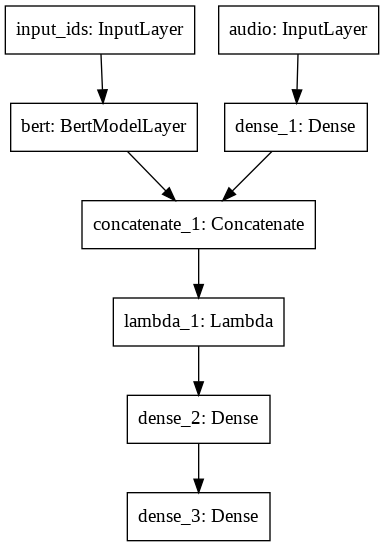

In [47]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [48]:
model.compile(optimizer = keras.optimizers.Adam(),loss = 'mse')

In [49]:
history = model.fit(x=[data.train_x,bigarray3],y=data.train_y,
  batch_size=1,
  epochs=10)

Epoch 1/10
100/100 [==============================] - 36s 267ms/step - loss: 17.1808
Epoch 2/10
100/100 [==============================] - 26s 264ms/step - loss: 16.4894
Epoch 3/10
100/100 [==============================] - 26s 263ms/step - loss: 17.7672
Epoch 4/10
100/100 [==============================] - 26s 260ms/step - loss: 18.2231
Epoch 5/10
100/100 [==============================] - 26s 263ms/step - loss: 18.1474
Epoch 6/10
100/100 [==============================] - 26s 263ms/step - loss: 16.6717
Epoch 7/10
100/100 [==============================] - 26s 264ms/step - loss: 16.9336
Epoch 8/10
100/100 [==============================] - 26s 264ms/step - loss: 17.6844
Epoch 9/10
100/100 [==============================] - 26s 264ms/step - loss: 17.0262
Epoch 10/10
100/100 [==============================] - 26s 262ms/step - loss: 17.6518


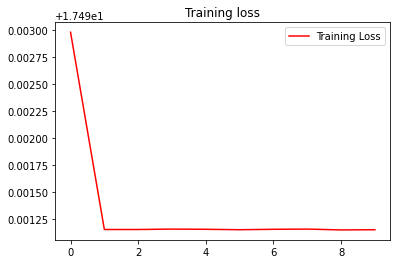

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.savefig('loss.png')
plt.show()